<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt

from torchvision import transforms

import numpy as np

from tqdm import tqdm
from sklearn.metrics import accuracy_score

from collections import namedtuple

In [3]:
from dul_2021.utils.hw12_utils import *

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [13]:
class SSDataset:
    def __init__(self, data, c=4000, train=True):
        self.data = data
        self.c = c
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        x, y = self.data[i]
        if not self.train:
            return x, y

        y = y if i < self.c else -1
        return x, y


def q12_results(q):
    train_data, test_data = get_data('CIFAR10')
    train_data, test_data = SSDataset(train_data), SSDataset(test_data, train=False)

    losses, accs = q(train_data, test_data)

    plot_training(losses, 'Loss')
    plot_training(accs, 'Accuracy')

In [100]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128, n_classes=11):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)
        self.last = nn.Linear(out_dim, n_classes)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.last(features)

In [7]:
class VAT(nn.Module):
    def __init__(self, lr, gamma):
        super().__init__()
        self.net = Net()
        self.net.to(device)
        self.crossentropy = nn.CrossEntropyLoss()
        self.optimizer = opt.Adam(self.net.parameters(), lr=lr)
        self.scheduler = opt.lr_scheduler.ExponentialLR(self.optimizer, gamma=gamma)
        self.softmax = nn.Softmax(-1)
        self.log_softmax = nn.LogSoftmax(-1)

    def l2_normalize(self, d):
        d_reshaped = d.view(d.shape[0], -1, * (1 for _ in range(d.dim() - 2)))
        d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
        return d

    def vat_loss(self, x, eps):
        with torch.no_grad():
          pred = self.softmax(self.net(x))
        
        random_unit_tensor = self.l2_normalize(
            torch.rand(x.shape).sub(0.5).to(device))
        random_unit_tensor.requires_grad_()

        pred_hat = self.log_softmax(self.net(x * eps + random_unit_tensor))
        kl_distance = F.kl_div(pred_hat, pred, reduction='batchmean')
        kl_distance.backward()

        r_adv = self.l2_normalize(random_unit_tensor.grad)
        self.net.zero_grad()
        pred_hat = self.log_softmax(self.net(x + r_adv))
        lds = F.kl_div(pred_hat, pred, reduction='batchmean')
        return lds
       
    def fit(self, train_loader, test_loader, lr, num_epochs, eps):
        losses = []
        accs = []
        
        for i in tqdm(range(num_epochs)):
            running_loss = 0
            n_batches = 0
            for (x, label) in train_loader:
                n_batches += 1

                x_l = x[label >= 0]
                y_l = label[label >= 0]

                x_ul = x[label < 0]
                y_ul = label[label < 0]

                # labeled data processing 
                labeled_class_probs = self.net(x_l.to(device))
                crossentropy_loss = self.crossentropy(
                    labeled_class_probs, y_l.to(device))
                
                # all data processing
                lds = self.vat_loss(x.to(device), eps)
                loss = crossentropy_loss + lds

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            losses.append(running_loss / n_batches)
            preds, true = self.decision_function_loader(test_loader)
            accs.append(accuracy_score(true, preds))
            self.scheduler.step()    

        return losses, accs
    
    def decision_function_loader(self, dataloader):
        y_pred = []
        y_true = []
        for x, y in dataloader:
            probas = torch.argmax(self.net(x.to(device).float()), 1)
            y_pred.extend(list(probas.squeeze().detach().cpu().numpy()))
            y_true.extend(list(y.squeeze().detach().cpu().numpy()))
        return y_pred, y_true

In [8]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    bs = 256
    lr = 5e-4
    eps = 10
    gamma = 0.99
    num_epochs = 15

    train_loader = torch.utils.data.DataLoader(train_data, bs, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, bs, shuffle=True)

    vat = VAT(lr, gamma)
    losses, accs = vat.fit(train_loader, test_loader, lr, num_epochs, eps)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [08:20<00:00, 33.37s/it]


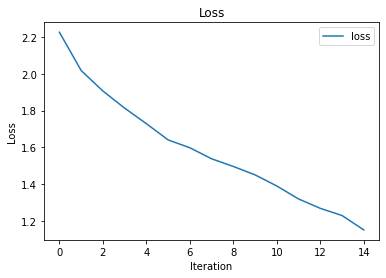

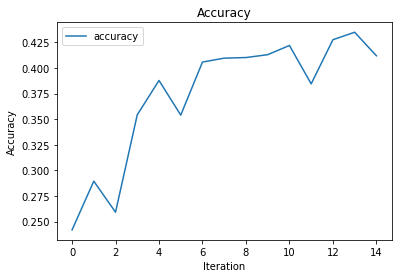

In [ ]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [131]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 2, 1)

        self.fc1 = nn.Linear(4 * 4 * 128, 128)
        self.fc2 = nn.Linear(128, 128)

        self.final = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.final(x)
        return x

In [135]:
class FixMatch:
    def __init__(self):
        """ 
            weak augmentation is a standard flip-and-shift augmentation strategy,
              - flip images horizontally with a probability of 50%
              - randomly translate images by up to 12.5% vertically and horizontally

            strong augmentation:
            RandAugment and CTAugment randomly select transformations for each sample
            
        """
        self.net = Model()
        self.net.to(device)
        self.tau = 0.7
        self.lambda_u = 10
        self.lr = 5e-4
        self.gamma = 0.99
        self.epochs = 50
        self.crossentropy = nn.CrossEntropyLoss()
        self.optimizer = opt.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = opt.lr_scheduler.ExponentialLR(self.optimizer, gamma=self.gamma)
        self.softmax = nn.Softmax(-1)

        self.weak_transforms = transforms.RandomHorizontalFlip(0.5)
        
        self.hard_transforms = transforms.Compose([
            transforms.ColorJitter(0.5, 0.5, 0.5, 0.1), 
            transforms.RandomResizedCrop(32), 
            transforms.RandomRotation(90),
            transforms.RandomGrayscale(0.2),
            transforms.Normalize((0.5), (0.5))
            ])
    
    def compute_loss_labeled_data(self, x, y):
        x = self.weak_transforms(x)
        predictions = self.net(x)
        loss = self.crossentropy(predictions, y)
        return loss.mean()
 
    def compute_loss_unlabeled_data(self, x):
        transformed_x = self.weak_transforms(x)
        prediction_probabilities = self.softmax(self.net(transformed_x))
        probabilities, labels = torch.max(prediction_probabilities, dim=1)
        mask = probabilities > self.tau

        # skip optimization if all samples 'unsure'
        if mask.sum() == 0:
            return 0

        predictions = self.net(self.hard_transforms(x[mask]))
        confident_labels = labels[mask]
        loss = self.crossentropy(predictions, confident_labels)
        return loss.mean()

    def decision_function_loader(self, dataloader):
        y_pred = []
        y_true = []

        for x, y in dataloader:
            probas = torch.argmax(self.net(x.to(device).float()), 1)
            y_pred.extend(list(probas.squeeze().detach().cpu().numpy()))
            y_true.extend(list(probas.squeeze().detach().cpu().numpy()))

        return y_pred, y_true
            
    def fit(self, train_loader, test_loader):
        train_losses = []
        test_accs = []

        for epoch in range(self.epochs):
            self.net.train()
            for x, labels in train_loader:
                x = x.to(device)
                labels = labels.to(device)

                x_l = x[labels >= 0]
                y_l = labels[labels >= 0]

                x_ul = x[labels < 0]

                labeled_loss = self.compute_loss_labeled_data(x_l, y_l)
                unlabeled_loss = self.compute_loss_unlabeled_data(x_ul)
                loss = labeled_loss + self.lambda_u * unlabeled_loss 

                if loss != 0:
                  self.optimizer.zero_grad()
                  loss.backward()
                  self.optimizer.step()

                train_losses.append(loss.item())

            # compute accs on tests data
            self.scheduler.step()
            y_true, y_pred = self.decision_function_loader(test_loader)
            test_accs.append(accuracy_score(y_true, y_pred))
        return train_losses, test_accs    


In [136]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    train_loader = torch.utils.data.DataLoader(train_data, 512, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(train_data, 512, shuffle=False, pin_memory=True)

    fix_match = FixMatch()
    losses, accs = fix_match.fit(train_loader, test_loader)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


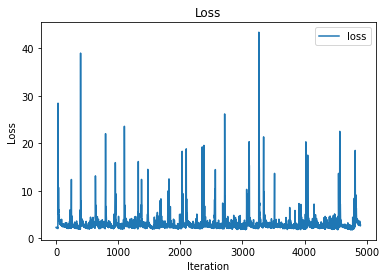

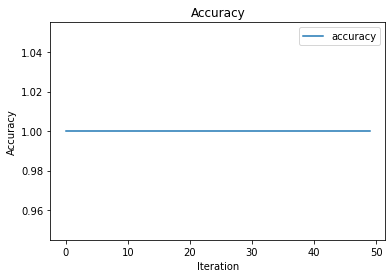

In [137]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """